In [1]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import pybedtools
import seaborn as sns
from pybedtools import BedTool
import sys
from tqdm import tqdm

import sys; sys.path.insert(0, "/storage/group/izg5139/default/nicole/g4_t2t_identification/scripts")
from dotenv import load_dotenv
loaded = load_dotenv("/storage/group/izg5139/default/nicole/g4_t2t_identification/scripts/.env")
print(loaded)
from constants import ConfigPaths
import pandas as pd
from pybedtools import BedTool
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# load g4hunter
g4_df = pd.read_table(ConfigPaths.G4HUNTER.value)
g4_bed = BedTool.from_dataframe(g4_df.drop(columns=['NBR'])).sort()

# load control group
control_df = pd.read_table(ConfigPaths.CONTROL_G4HUNTER.value)
control_bed = BedTool.from_dataframe(control_df).sort()

genome_size = pd.read_table(ConfigPaths.GENOME_SIZE.value, header=None)[1].sum()

# test validity of control group
g4_gw_density = pd.read_table(
                            g4_bed.sort().merge().fn, 
                            header=None, 
                            names=["seqID", "start", "end"]
)
g4_gw_density["size"] = g4_gw_density["end"] - g4_gw_density["start"]
g4_gw_density = g4_gw_density["size"].sum() * 1e6 / genome_size

# CONTROL DENSITY
control_gw_density = pd.read_table(
                            control_bed.sort().merge().fn, header=None, names=["seqID", "start", "end"]
)
control_gw_density["size"] = control_gw_density["end"] - control_gw_density["start"]
control_gw_density = control_gw_density["size"].sum() * 1e6 / genome_size

g4_gw_density, control_gw_density

True


(17745.228794041104, 22841.721083902157)

In [2]:
from gff_utils import Expander, GFFExtractor

In [3]:
mutation_paths = {file.name.split('.')[-2].split("_")[-1]: file for file in Path("/storage/group/izg5139/default/nicole/g4_t2t/mutations/").glob("*.bed")}
mutation_paths

{'complexdel': PosixPath('/storage/group/izg5139/default/nicole/g4_t2t/mutations/mutation_merged_complexdel.bed'),
 'complexins': PosixPath('/storage/group/izg5139/default/nicole/g4_t2t/mutations/mutation_merged_complexins.bed'),
 'del': PosixPath('/storage/group/izg5139/default/nicole/g4_t2t/mutations/mutation_merged_del.bed'),
 'ins': PosixPath('/storage/group/izg5139/default/nicole/g4_t2t/mutations/mutation_merged_ins.bed'),
 'mnp': PosixPath('/storage/group/izg5139/default/nicole/g4_t2t/mutations/mutation_merged_mnp.bed'),
 'smalldel': PosixPath('/storage/group/izg5139/default/nicole/g4_t2t/mutations/mutation_merged_smalldel.bed'),
 'smallins': PosixPath('/storage/group/izg5139/default/nicole/g4_t2t/mutations/mutation_merged_smallins.bed'),
 'snp': PosixPath('/storage/group/izg5139/default/nicole/g4_t2t/mutations/mutation_merged_snp.bed')}

In [22]:
g4_df = g4_df.query("seqID != 'chrY'")

## Venn Overlap

In [23]:
g4_bed = BedTool.from_dataframe(g4_df.drop(columns=['NBR'])).sort()
g4_bed.count()

2065697

In [27]:
from gff_utils import CoverageExtractor

mutation_sets = dict()

for mut, path in tqdm(mutation_paths.items()):
    df = pd.read_table(path)
    
    df_merged = pl.read_csv(
                    g4_bed.coverage(BedTool.from_dataframe(df).sort()).fn,
                    has_header=False,
                    separator="\t",
                    new_columns=list(g4_df.columns.drop(['NBR'])) + CoverageExtractor.COVERAGE_FIELDS)\
         .filter(pl.col("coverage") > 0)\
         .with_columns(coords=pl.col("seqID") + "_" + pl.col("start").cast(pl.Utf8) + "_" + pl.col("end").cast(pl.Utf8)).select(["coords"])

    mutation_sets[mut] = set(df_merged["coords"])

100%|██████████| 8/8 [02:03<00:00, 15.45s/it]


In [28]:
!pip install venn

  Preparing metadata (setup.py) ... done
  Created wheel for venn: filename=venn-0.1.3-py3-none-any.whl size=19701 sha256=533b05c5a049df2f5bcaf7fda97a638e68f06c5f87b9bcadcdf45fbbdad4cb5f
  Stored in directory: /storage/home/nmc6088/.cache/pip/wheels/9c/ce/43/705b4a04cd822891d1d7a4c43fc444b4798978e72c79528c5f
Successfully built venn


In [29]:
mutation_sets.keys()

dict_keys(['complexdel', 'complexins', 'del', 'ins', 'mnp', 'smalldel', 'smallins', 'snp'])

In [30]:
del mutation_sets['complexdel']
del mutation_sets['complexins']
len(mutation_sets)

6

In [35]:
!pip install matplotlib_venn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for matplotlib_venn: filename=matplotlib_venn-1.1.2-py3-none-any.whl size=45388 sha256=5efad4111ffc74e25d0a68fecc8f169f9dce232cda746030c5d15230f3dd0c11
  Stored in directory: /storage/home/nmc6088/.cache/pip/wheels/51/7e/04/79020d177ea85e21043f09b451e3a7d093f919ac874cadd4b2
Successfully built matplotlib_venn


In [42]:
from matplotlib_venn import venn3

In [48]:
type(g4_df)

pandas.core.frame.DataFrame

In [49]:
g4_df_coords = pl.from_pandas(g4_df).with_columns(coords=pl.col("seqID") + "_" + pl.col("start").cast(pl.Utf8) + "_" + pl.col("end").cast(pl.Utf8)).select(["coords"])
global_g4 = set(g4_df_coords["coords"])
len(global_g4)

2065697

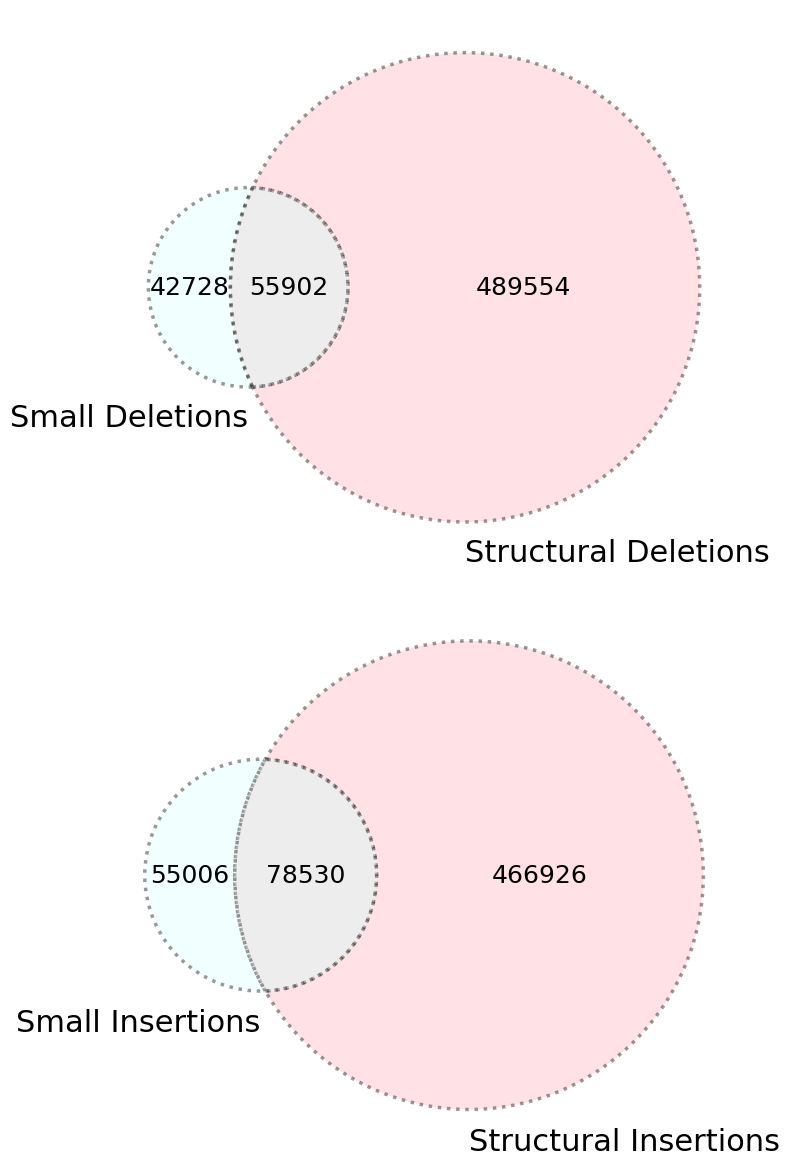

In [69]:

from matplotlib_venn import venn2

fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(14, 12))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
v = venn2(subsets=(mutation_sets['del'], mutation_sets['snp']), 
          set_labels=('Small Deletions', 'Structural Deletions'), 
          ax=ax[0])

colors = ['lightcyan', 'lightpink', 'lightgrey']  # Left and right circle colors
for i, patch in enumerate(v.patches):
    if patch:
        patch.set_facecolor(colors[i])
        patch.set_edgecolor('black')
        patch.set_linestyle('dotted')
        patch.set_linewidth(2.5)

# Adjust text sizes
for text in v.set_labels:
    text.set_fontsize(22)
for text in v.subset_labels:
    if text:
        text.set_fontsize(18)

v = venn2(subsets=(mutation_sets['smalldel'], mutation_sets['snp']), 
          set_labels=('Small Insertions', 'Structural Insertions'), 
          ax=ax[1])

colors = ['lightcyan', 'lightpink', 'lightgrey']  # Left and right circle colors
for i, patch in enumerate(v.patches):
    if patch:
        patch.set_facecolor(colors[i])
        patch.set_edgecolor('black')
        patch.set_linestyle('dotted')
        patch.set_linewidth(2.5)

# Adjust text sizes
for text in v.set_labels:
    text.set_fontsize(22)
for text in v.subset_labels:
    if text:
        text.set_fontsize(18)

plt.tight_layout()
target = Path("/storage/group/izg5139/default/nicole/g4_t2t_identification/figures/venn")
target.mkdir(exist_ok=True)
# fig.savefig(f"{target}/g4_snp_dels_smalldels_ins_smallins_comparison.pdf", bbox_inches='tight', dpi=600)
plt.show()

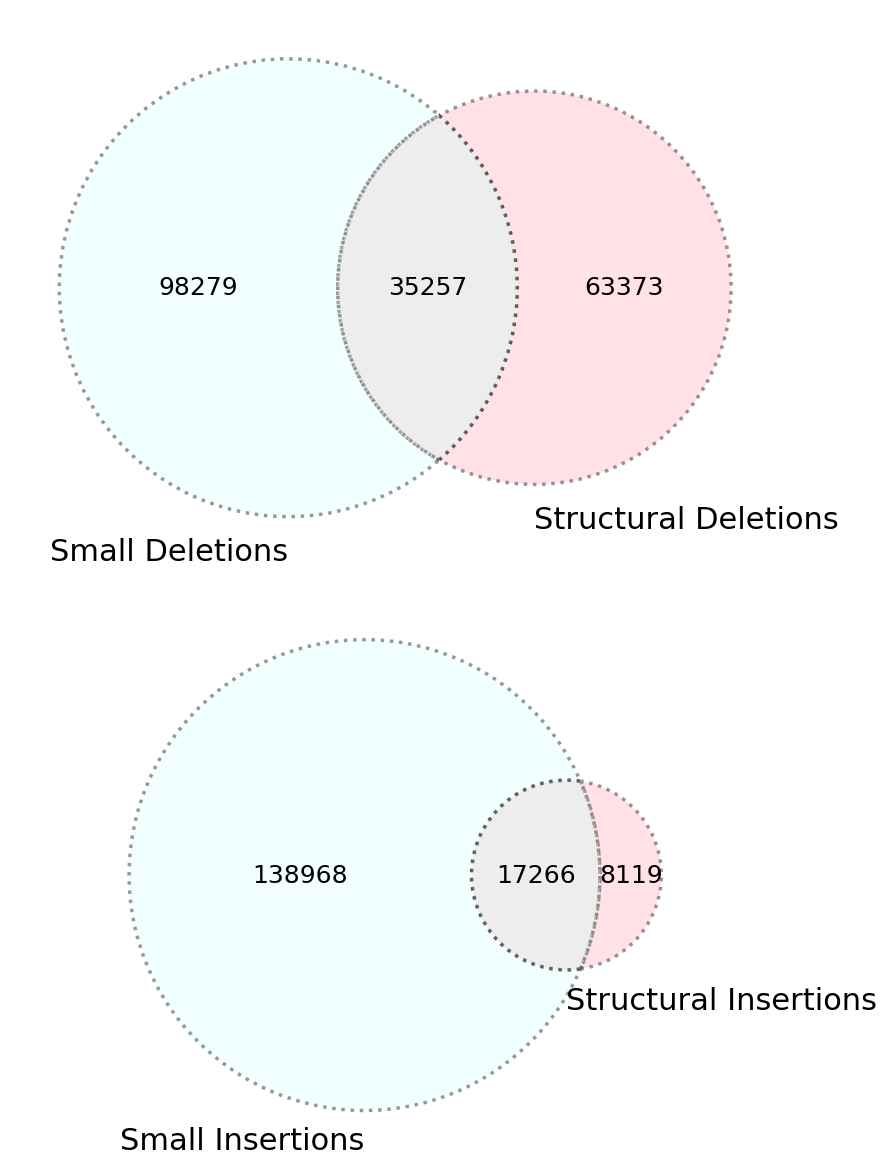

In [65]:

from matplotlib_venn import venn2

fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(14, 12))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
v = venn2(subsets=(mutation_sets['smalldel'], mutation_sets['del']), set_labels=('Small Deletions', 'Structural Deletions'), ax=ax[0])

colors = ['lightcyan', 'lightpink', 'lightgrey']  # Left and right circle colors
for i, patch in enumerate(v.patches):
    if patch:
        patch.set_facecolor(colors[i])
        patch.set_edgecolor('black')
        patch.set_linestyle('dotted')
        patch.set_linewidth(2.5)

# Adjust text sizes
for text in v.set_labels:
    text.set_fontsize(22)
for text in v.subset_labels:
    if text:
        text.set_fontsize(18)

v = venn2(subsets=(mutation_sets['smallins'], mutation_sets['ins']), 
          set_labels=('Small Insertions', 'Structural Insertions'), 
          ax=ax[1])

colors = ['lightcyan', 'lightpink', 'lightgrey']  # Left and right circle colors
for i, patch in enumerate(v.patches):
    if patch:
        patch.set_facecolor(colors[i])
        patch.set_edgecolor('black')
        patch.set_linestyle('dotted')
        patch.set_linewidth(2.5)

# Adjust text sizes
for text in v.set_labels:
    text.set_fontsize(22)
for text in v.subset_labels:
    if text:
        text.set_fontsize(18)

plt.tight_layout()
target = Path("/storage/group/izg5139/default/nicole/g4_t2t_identification/figures/venn")
target.mkdir(exist_ok=True)
fig.savefig(f"{target}/g4_dels_smalldels_ins_smallins_comparison.pdf", bbox_inches='tight', dpi=600)
plt.show()

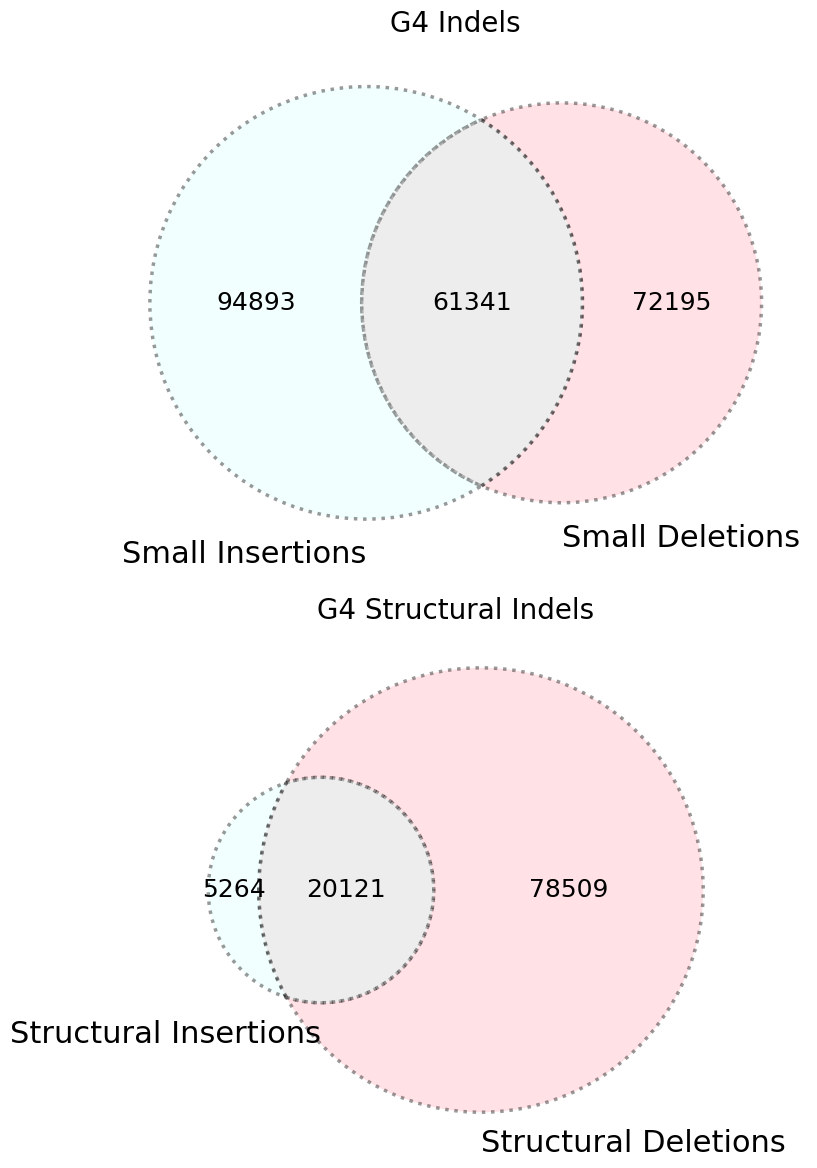

In [63]:

from matplotlib_venn import venn2

fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(14, 12))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
v = venn2(subsets=(mutation_sets['smallins'], mutation_sets['smalldel']), set_labels=('Small Insertions', 'Small Deletions'), ax=ax[0])

colors = ['lightcyan', 'lightpink', 'lightgrey']  # Left and right circle colors
for i, patch in enumerate(v.patches):
    if patch:
        patch.set_facecolor(colors[i])
        patch.set_edgecolor('black')
        patch.set_linestyle('dotted')
        patch.set_linewidth(2.5)

# Adjust text sizes
for text in v.set_labels:
    text.set_fontsize(22)
for text in v.subset_labels:
    if text:
        text.set_fontsize(18)
ax[0].set_title("G4 Indels", fontsize=20)


v = venn2(subsets=(mutation_sets['ins'], mutation_sets['del']), set_labels=('Structural Insertions', 'Structural Deletions'), ax=ax[1])

colors = ['lightcyan', 'lightpink', 'lightgrey']  # Left and right circle colors
for i, patch in enumerate(v.patches):
    if patch:
        patch.set_facecolor(colors[i])
        patch.set_edgecolor('black')
        patch.set_linestyle('dotted')
        patch.set_linewidth(2.5)

# Adjust text sizes
for text in v.set_labels:
    text.set_fontsize(22)
for text in v.subset_labels:
    if text:
        text.set_fontsize(18)

ax[1].set_title("G4 Structural Indels", fontsize=20)
plt.tight_layout()
target = Path("/storage/group/izg5139/default/nicole/g4_t2t_identification/figures/venn")
target.mkdir(exist_ok=True)
fig.savefig(f"{target}/g4_indels_comparison.pdf", bbox_inches='tight', dpi=300)
plt.show()

In [4]:
pybedtools.set_tempdir("/scratch/nmc6088")

In [5]:
window_size = 2000
e = Expander(window_size=window_size)
mutation_beds = dict()

for mut, path in tqdm(mutation_paths.items()):
    df = pd.read_table(path)
    df_merged = pl.read_csv(
                    BedTool.from_dataframe(df).sort().merge().fn,
                    has_header=False,
                    separator="\t",
                    new_columns=["seqID", "start", "end"]
                ).with_columns(
                           mutation=pl.lit(mut), 
                           strand=pl.lit("+")
                    )
    
    df_merged_expanded = e.expand_windows(df_merged, loci="mid")
    df_merged_expanded_bed = BedTool.from_dataframe(df_merged_expanded.to_pandas()).sort()
    mutation_beds[mut] = df_merged_expanded_bed

100%|██████████| 8/8 [05:56<00:00, 44.51s/it] 


In [10]:
control_regex_df = pd.read_table(ConfigPaths.CONTROL_G4REGEX.value)
control_regex_bed = BedTool.from_dataframe(control_regex_df[["seqID", "start", "end"]]).sort().merge()

regex_df = pd.read_table(ConfigPaths.G4REGEX.value)
regex_bed = BedTool.from_dataframe(regex_df[["seqID", "start", "end"]]).sort().merge()
regex_df

,seqID,start,end,sequence,strand,length
0,chr1,2,25,CCCTAAACCCTAACCCCTAACCC,-,23
1,chr1,28,49,CCCTAACCCTAACCCTAACCC,-,21
2,chr1,52,75,CCCCTAAACCCTAACCCTAACCC,-,23
3,chr1,78,99,CCCTAACCCTAACCCTAACCC,-,21
4,chr1,102,123,CCCTAACCCTAACCCTAACCC,-,21
...,...,...,...,...,...,...
414899,chrM,2988,3012,CCCCCCTCCCCATACCCAACCCCC,-,24
414900,chrM,7674,7708,CCCGTATTTACCCTATAGCACCCCCTCTACCCCC,-,34
414901,chrM,9606,9631,CCCTATATCCCCCGCCCGCGTCCCC,-,25
414902,chrM,11784,11813,CCCTAACCCTGACTTCCCTAATTCCCCCC,-,29


In [ ]:
from tqdm import tqdm
import numpy as np
from pwm_density import PWMExtractor
extractor = PWMExtractor()
mutation_densities = dict()

mutations = ["snp", "smalldel", "smallins", "mnp", "del", "ins"]
for mut in tqdm(mutations):
    print(mut)
    mut_bed = mutation_beds[mut]
    intersect_df = pl.read_csv(
                        mut_bed.intersect(regex_bed, wo=True).fn,
                        has_header=False,
                        separator="\t",
                        new_columns=["seqID", "start", "end", "mutation", "strand", "mid"] + ["chrom", "motif_start", "motif_end", "overlap"]
    )
    
    density = extractor.extract_density(intersect_df, window_size=window_size)
    density = density / np.mean(density)
    mutation_densities[mut, "regex", "g4"] = density

    intersect_df_control = pl.read_csv(
                        mut_bed.intersect(control_regex_bed, wo=True).fn,
                        has_header=False,
                        separator="\t",
                        new_columns=["seqID", "start", "end", "mutation", "strand", "mid"] + ["chrom", "motif_start", "motif_end", "overlap"]
    )
    
    control_density = extractor.extract_density(intersect_df_control, window_size=window_size)
    control_density = control_density / np.mean(control_density)
    mutation_densities[mut, "regex", "control"] = control_density

  0%|          | 0/6 [00:00<?, ?it/s]

snp


In [ ]:
mutations = ["snp", "smalldel", "smallins", "mnp", "del", "ins"]
for mut in tqdm(mutations):
    print(mut)
    mut_bed = mutation_beds[mut]
    intersect_df = pl.read_csv(
                        mut_bed.intersect(g4_bed, wo=True).fn,
                        has_header=False,
                        separator="\t",
                        new_columns=["seqID", "start", "end", "mutation", "strand", "mid"] + ["chrom", "motif_start", "motif_end", "overlap"]
    )
    
    density = extractor.extract_density(intersect_df, window_size=window_size)
    density = density / np.mean(density)
    mutation_densities[mut, "g4hunter", "g4"] = density

    intersect_df_control = pl.read_csv(
                        mut_bed.intersect(control_bed, wo=True).fn,
                        has_header=False,
                        separator="\t",
                        new_columns=["seqID", "start", "end", "mutation", "strand", "mid"] + ["chrom", "motif_start", "motif_end", "overlap"]
    )
    
    control_density = extractor.extract_density(intersect_df_control, window_size=window_size)
    control_density = control_density / np.mean(control_density)
    mutation_densities[mut, "g4hunter", "control"] = control_density

In [ ]:
from matplotlib.pyplot import Rectangle
MODE = "regex"


palette_group = {"control": "#8f90a8",
                 "g4": "#da48c0",
                }
methylation_types = ["CHM13v2", "HG002"]
methylation_levels = ["Hypomethylated", "Methylated", "Hypermethylated"]
mutations = ["snp", "smallins", "smalldel", "mnp", "ins", "del"]

palette = {
           1: sns.color_palette("Set3")[-4], 
           0: sns.color_palette("Set3")[2]
}

window_size = 2000
linewidth = 2.6
mode = "g4hunter"
xaxis = range(-window_size, window_size+1)
color = "#eb4dc0"

mutation_titles = {
                   "smalldel": "Small Deletion",
                   "smallins": "Small Insertion",
                   "ins": "Structural Insertion",
                 "del": "Structural Deletion",
                  "snp": "Substitution",
                 "mnp": "Multiple Nucleotide Polymorphism",
                  }

def _modify_axis(ax, transcription_site):
    # xticks = ax.get_xticks()
    # ax.set_xticks(range(0, len(xticks), 100))
    if transcription_site == "start":
        # ax.set_ylabel("")
        ax.set_ylabel("Enrichment")
    else:
        ax.set_ylabel("")
    ax.set_ylabel("")
    # ax.legend(prop={"size": 14}, frameon=False, shadow=False)
        
    ax.yaxis.label.set_size(20)
    ax.xaxis.label.set_size(16)
    ax.tick_params(axis="both", which="major", labelsize=14)
    # if idx != 9 or idx != 8:
    #    ax.set_xticklabels([])
    ax.grid(axis="both", lw=0.6, alpha=0.6, zorder=0)
    ax.axvline(0, linestyle='--', color='black', lw=2.0)
    ax.axhline(1.0, linestyle='--', color='crimson', lw=2.5, zorder=5)
    return ax
    
print(mutations)
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(22, 10))
fig.subplots_adjust(hspace=0.3, wspace=0.18)
ax = ax.flatten()

for i, mutation in enumerate(mutations):
    cur_ax = ax[i]
    
    for group in ["control", "g4"]:
        cols = list(map(str,range(-window_size, window_size+1)))
        cur_ax.plot(xaxis, 
                        mutation_densities[mutation, MODE, group],
                        color=palette_group[group],
                        lw=linewidth, 
                        zorder=3,
                        label=None)
        
        # cur_ax.fill_between(
        #                 xaxis,
        #                 density['q0025'],
        #                 density['q0975'],
        #                 color=palette_group[group],
        #                 alpha=0.2,
        # )
        site = "start" if i == 0 else ""
        cur_ax = _modify_axis(cur_ax, transcription_site=site)
        # cur_ax.set_ylim(ymax=3.0)
        cur_ax.set_ylim(ymax=2.3)

    if i == 2 or i == 5:
        fig.canvas.draw()

        bbox = ax[i].get_position()
        rect_width = 0.035
        rect_left = bbox.x1
        rect_height = bbox.y1 - bbox.y0
        rect_bottom = bbox.y0

        fig.patches.append(Rectangle((rect_left, rect_bottom), 
                                     rect_width, rect_height,
                                     edgecolor="black",
                                     linewidth=2.0,
                                     transform=fig.transFigure, facecolor='gray', alpha=0.5))
        
        # Add title text
        fig.text(rect_left + rect_width / 2, 
                 rect_bottom + rect_height / 2, 
                 s="Enrichment",
                 ha='center', 
                 va='center', 
                 color='black',
                 rotation=270,
                 fontsize=18
                )
# ax[idx][i].set_ylim(ymax=2.2)

    fig.canvas.draw()
    # Get the bounding box of the second subplot in figure coordinates
    bbox = ax[i].get_position()
    rect_height = 0.06 # Height of the rectangle relative to figure
    rect_bottom = bbox.y1  # Bottom of the rectangle aligns with the top of the subplot
    rect_left = bbox.x0  # Left aligns with the subplot
    rect_width = bbox.x1 - bbox.x0  # Width matches the subplot
    
    # Add rectangle
    fig.patches.append(Rectangle((rect_left, rect_bottom), 
                                 rect_width, 
                                 rect_height,
                                 edgecolor="black",
                                 linewidth=2.0,
                                 transform=fig.transFigure, facecolor='gray', alpha=0.5))
    
    # Add title text
    fig.text(rect_left + rect_width / 2, 
             rect_bottom + rect_height / 2, 
             # title=site, 
             s=mutation_titles[mutation],
             ha='center', 
             va='center', 
             color='black', 
             fontsize=18
            )

# target = Path("G4_figures_RTR")
# target.mkdir(exist_ok=True, parents=True)
# fig.savefig(f"{target}/TSS_TES_distribution_exons_chordata_ascomycota_{mode}.png", bbox_inches="tight")
# fig.suptitle(phylum, fontsize=28)

target = Path("/storage/group/izg5139/default/nicole/g4_t2t_identification/figures/mutations_2kb").resolve()
target.mkdir(exist_ok=True)
fig.savefig(f"{target}/2kb_distribution_G4_CONTROL_mutations_{MODE}.pdf", format="pdf", dpi=600, bbox_inches="tight")